In [3]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions

import numpy as np
torch.manual_seed(0)
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

from flow_ssl.realnvp.realnvp_toy import RealNVP
from datasets import make_circles_ssl, make_moons_ssl, make_github_cat, make_npz
from flow_ssl.distributions import SSLGaussMixture

%load_ext autoreload
%autoreload 2

In [4]:
def make_net(D, num_hidden, hidden, activation=nn.Tanh):
    layers = [nn.Linear(D, hidden), activation(), nn.BatchNorm1d(hidden)]
    for _ in range(num_hidden):
        layers.append(nn.Linear(hidden, hidden))
        layers.append(activation())
        layers.append(nn.BatchNorm1d(hidden))
    layers.append(nn.Linear(hidden, 1))
    return  nn.Sequential(*layers)

def compute_loss(net, prior, x, y, label_weight):
    z = net(x)
    return -(prior.log_prob(z, y, label_weight)).mean()

In [5]:
def grid_image(mapping, xx, yy, extradim=False):
    lines = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    if extradim:
        lines = lines[:, None, :]
    lines = torch.from_numpy(lines).float()
    img_lines = mapping(lines).detach().numpy()
    
    if extradim:
        img_xx, img_yy = img_lines[:, 0, 0], img_lines[:, 0, 1]
    else:
        img_xx, img_yy = img_lines[:, 0], img_lines[:, 1]
    img_xx = img_xx.reshape(xx.shape)
    img_yy = img_yy.reshape(yy.shape)
    return img_xx, img_yy, img_lines

## Moons

In [18]:
r = 1.5
means = torch.tensor([[r, -r], [-r, r]])
prior = SSLGaussMixture(means=means)

data, labels = make_moons_ssl()

net = make_net(D=2, num_hidden=3, hidden=50)

In [19]:
lr_init = 1.
epochs = 2001
batch_size = 20
n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
label_weight = n_ul / n_l
print_freq = 500
label_weight *= 1
label_weight = 1.

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=lr_init)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    
    loss = compute_loss(net, prior, batch_x, batch_y, label_weight)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

iter 0: loss = 3.639
iter 500: loss = 3.632
iter 1000: loss = 3.626
iter 1500: loss = 3.626
iter 2000: loss = 3.626


(1000, 1)


(-1.5, 2.5)

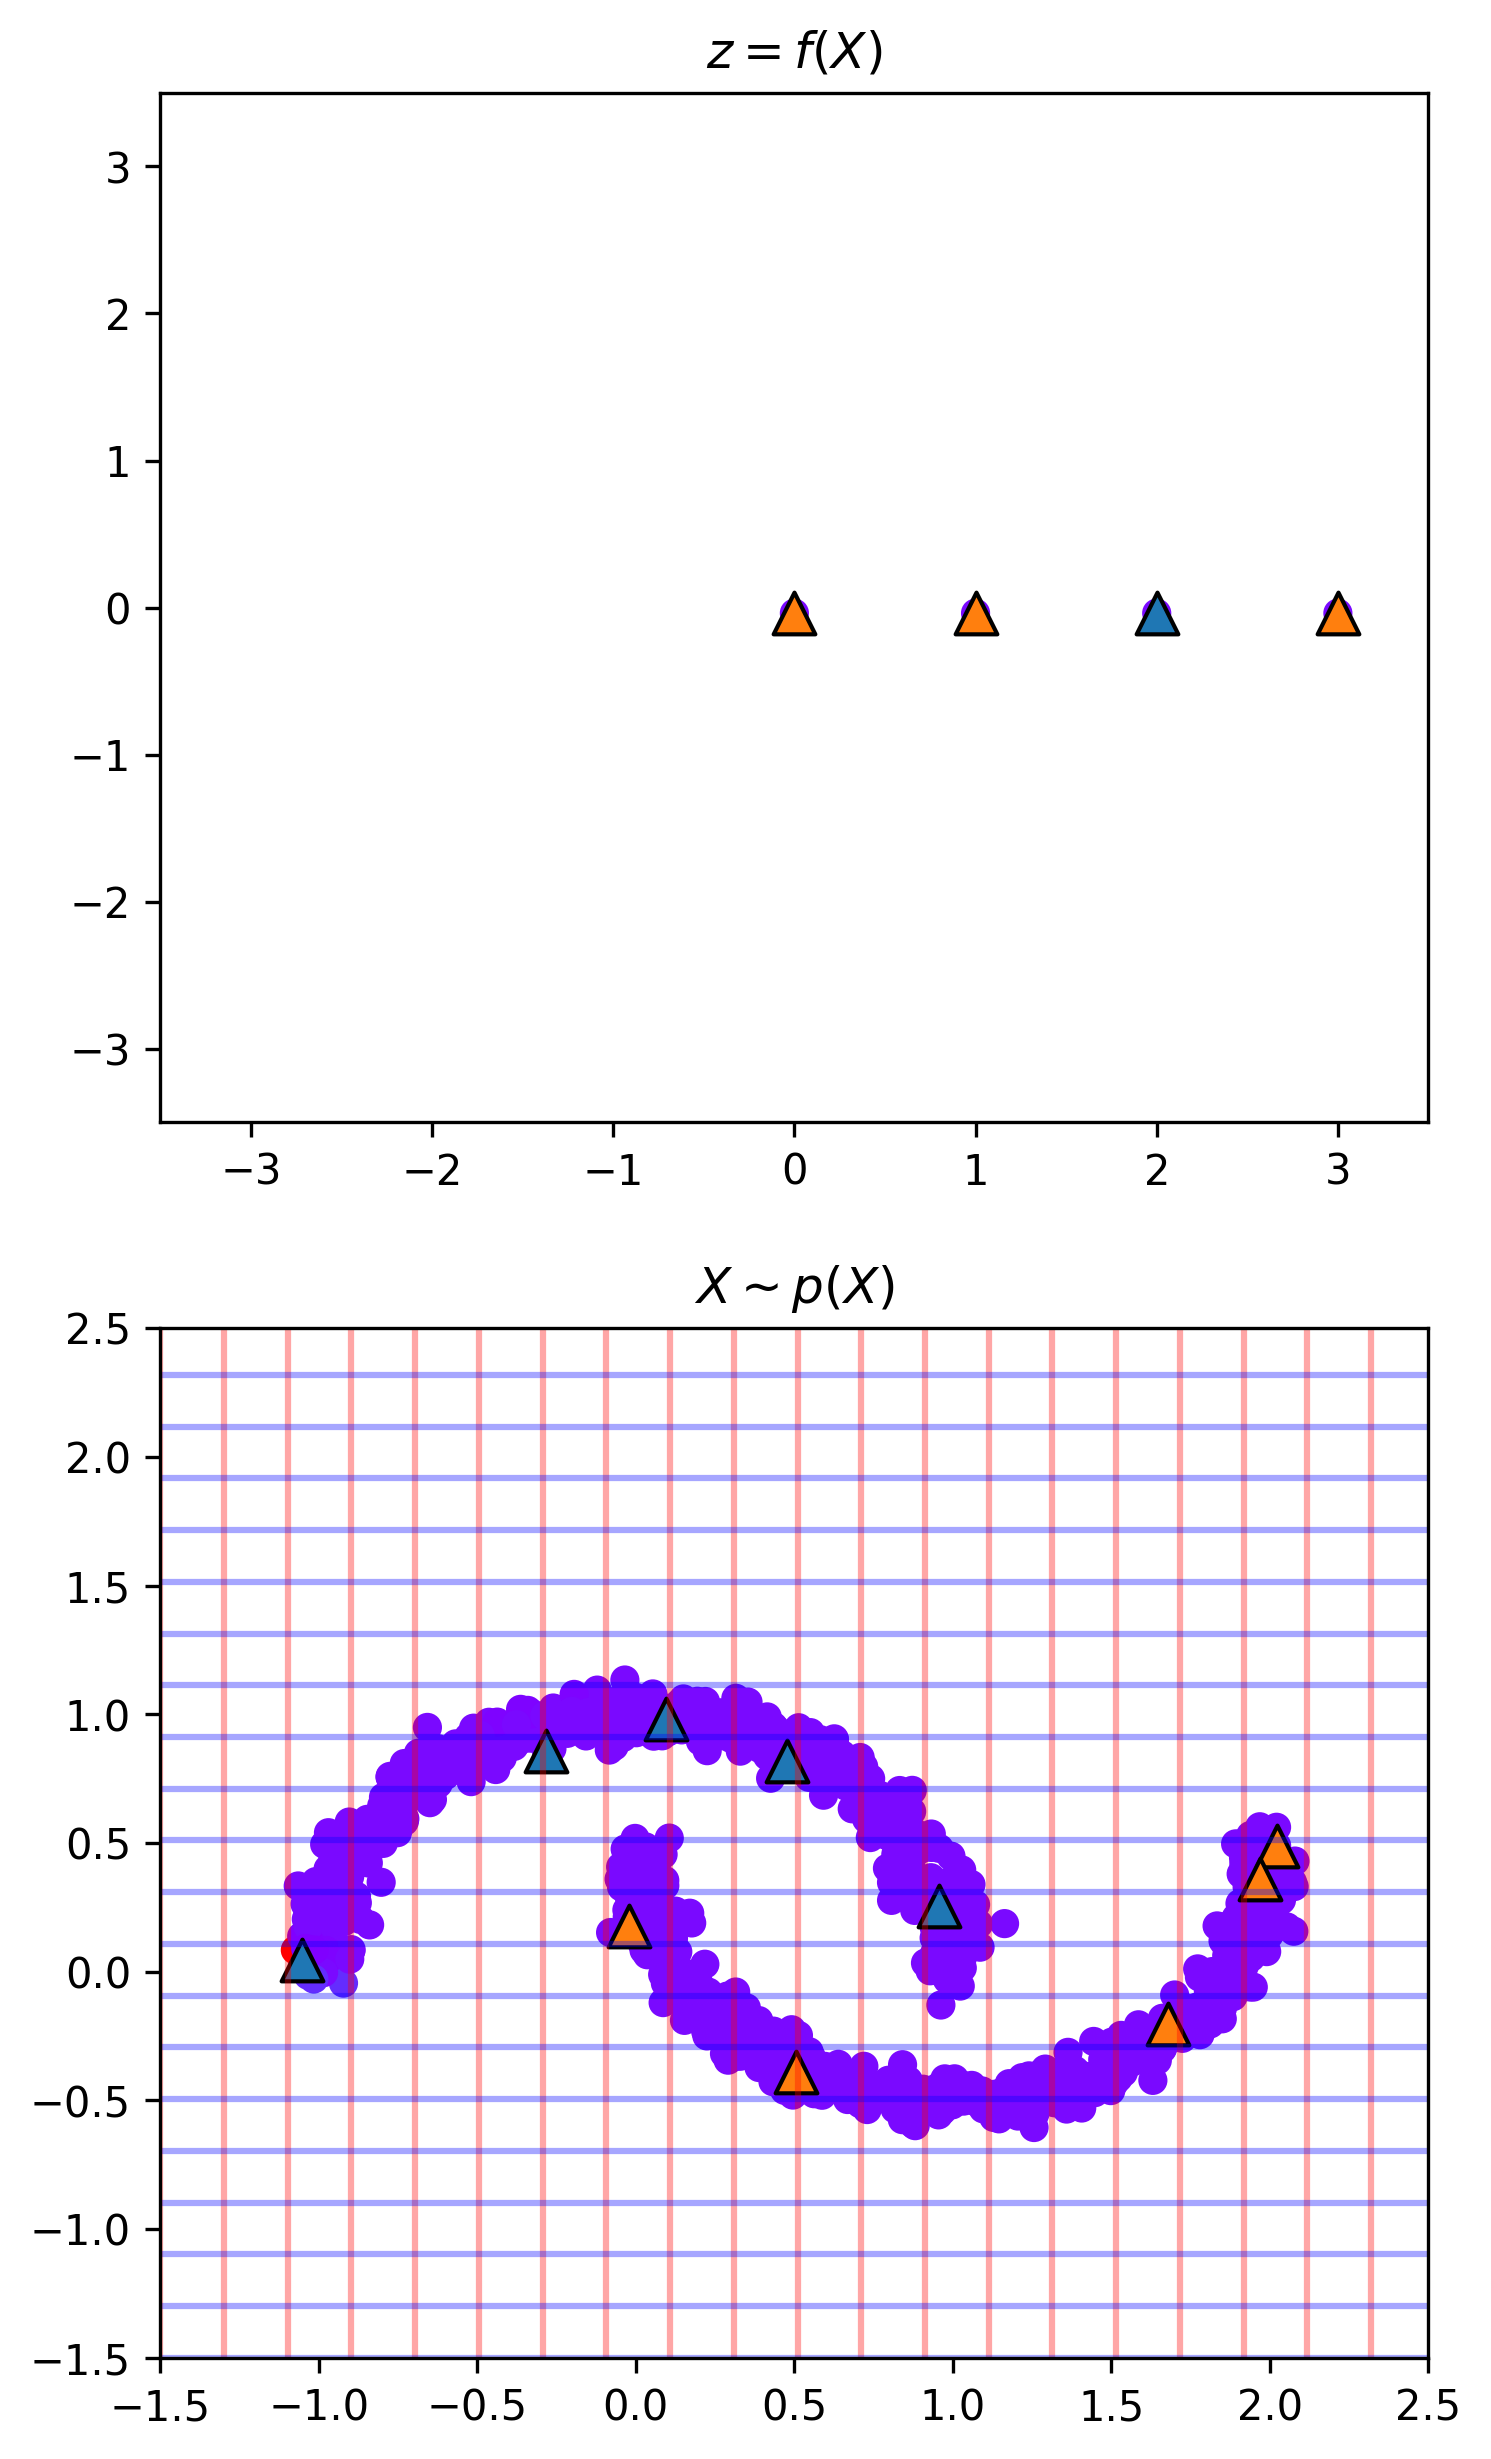

In [29]:
plt.figure(figsize=(12, 10))


grid_points = 200
grid_freq = 10
z_lims = [-3.5, 3.5]
x_lims = [-1.5, 2.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = net(torch.from_numpy(data)).detach().numpy()
print(inv.shape)


plt.subplot(221)
ys = np.arange(len(inv[:, 0]))
plt.scatter(ys, inv[:, 0], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(ys[labels==0], inv[labels==0], marker="^", s=100, edgecolor="k")
plt.scatter(ys[labels==1], inv[labels==1], marker="^", s=100, edgecolor="k")
# f_xx, f_yy = grid_image(net, xx_x, yy_x)
# plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
# f_xx, f_yy = grid_image(net, yy_x, xx_x)
# plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(223)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(data[labels==0][:, 0], data[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(data[labels==1][:, 0], data[labels==1][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

## Circles

In [398]:
r = 1.5
# means = torch.tensor([[r, -r], [-r, r]])
means = torch.tensor([[r], [-r]])
prior = SSLGaussMixture(means=means, cov_std=0.5)

data, labels = make_circles_ssl()

net = make_net(D=2, num_hidden=2, hidden=50)

In [ ]:
lr_init = 1e-2
epochs = 10001
batch_size = 1
n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
label_weight = n_ul / n_l
print_freq = 500
label_weight *= 1

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=lr_init, weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    
    loss = compute_loss(net, prior, batch_x, batch_y, label_weight)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

iter 0: loss = -1.002
iter 500: loss = -57.276
iter 1000: loss = -59.581
iter 1500: loss = -57.758
iter 2000: loss = -58.139
iter 2500: loss = -57.344
iter 3000: loss = -59.156
iter 3500: loss = -58.172
iter 4000: loss = -59.479


In [ ]:
plt.figure(figsize=(12, 10))

inv = net(torch.from_numpy(data)).detach().numpy()

z_lims = [-6.5, 6.5]
x_lims = [-1.5, 1.5]
plt.subplot(221)
plt.scatter(inv, np.zeros_like(inv), c=inv, cmap=plt.cm.rainbow)
plt.scatter(inv[labels==0], np.zeros_like(inv)[labels==0], marker="^", s=100, edgecolor="k")
plt.scatter(inv[labels==1], np.zeros_like(inv)[labels==1], marker="^", s=100, edgecolor="k")
# f_xx, f_yy = grid_image(net, xx_x, yy_x)
# plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
# f_xx, f_yy = grid_image(net, yy_x, xx_x)
# plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
# plt.xlim(z_lims)
# plt.ylim(z_lims)

plt.subplot(223)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(data[labels==0][:, 0], data[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(data[labels==1][:, 0], data[labels==1][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.contour(xx_x, yy_x, zz, levels=[0.5])
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

In [361]:
plt.figure(figsize=(12, 10))


grid_points = 100
grid_freq = 10
z_lims = [-3.5, 3.5]
x_lims = [-1.5, 1.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)
xx_x, yy_x = np.meshgrid(line_x, line_x)
f_xx, f_yy, f_lines = grid_image(net, xx_x, yy_x)


Z = np.sum((f_lines[:, None, :] - means.numpy()[None, :, :])**2, axis=2)
Z = np.exp(-Z)
Z /= np.sum(Z, axis=1)[:, None]
# Z.shape
zz = Z[:, 0]
zz = zz.reshape(xx_x.shape)
# zz.shape

inv = net(torch.from_numpy(data)).detach().numpy()


plt.subplot(221)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(inv[labels==0][:, 0], inv[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(inv[labels==1][:, 0], inv[labels==1][:, 1], marker="^", s=100, edgecolor="k")
# f_xx, f_yy = grid_image(net, xx_x, yy_x)
# plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
# f_xx, f_yy = grid_image(net, yy_x, xx_x)
# plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
# plt.xlim(z_lims)
# plt.ylim(z_lims)

plt.subplot(223)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(data[labels==0][:, 0], data[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(data[labels==1][:, 0], data[labels==1][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.contour(xx_x, yy_x, zz, levels=[0.5])
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 864x720 with 0 Axes>

## Cat

In [65]:
means = torch.zeros((1, 2))
prior = SSLGaussMixture(means=means)

data, labels = make_github_cat("github.png")

flow = get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=6, inner_layers=2)

In [63]:
lr_init = 3e-4
epochs = 2001
batch_size = 100
n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
label_weight = 1.
print_freq = 500

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_l + n_ul, size=batch_size)
    batch_x, batch_y = data[batch_idx], labels[batch_idx]
    batch_x, batch_y = torch.from_numpy(batch_x).float(), torch.from_numpy(batch_y).float()
    
    loss = -flow.log_prob(batch_x, batch_y, label_weight).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

/home/izmailovpavel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  


iter 0: loss = 4.343
iter 500: loss = 3.294
iter 1000: loss = 3.256
iter 1500: loss = 3.236
iter 2000: loss = 3.189


(-4, 4)

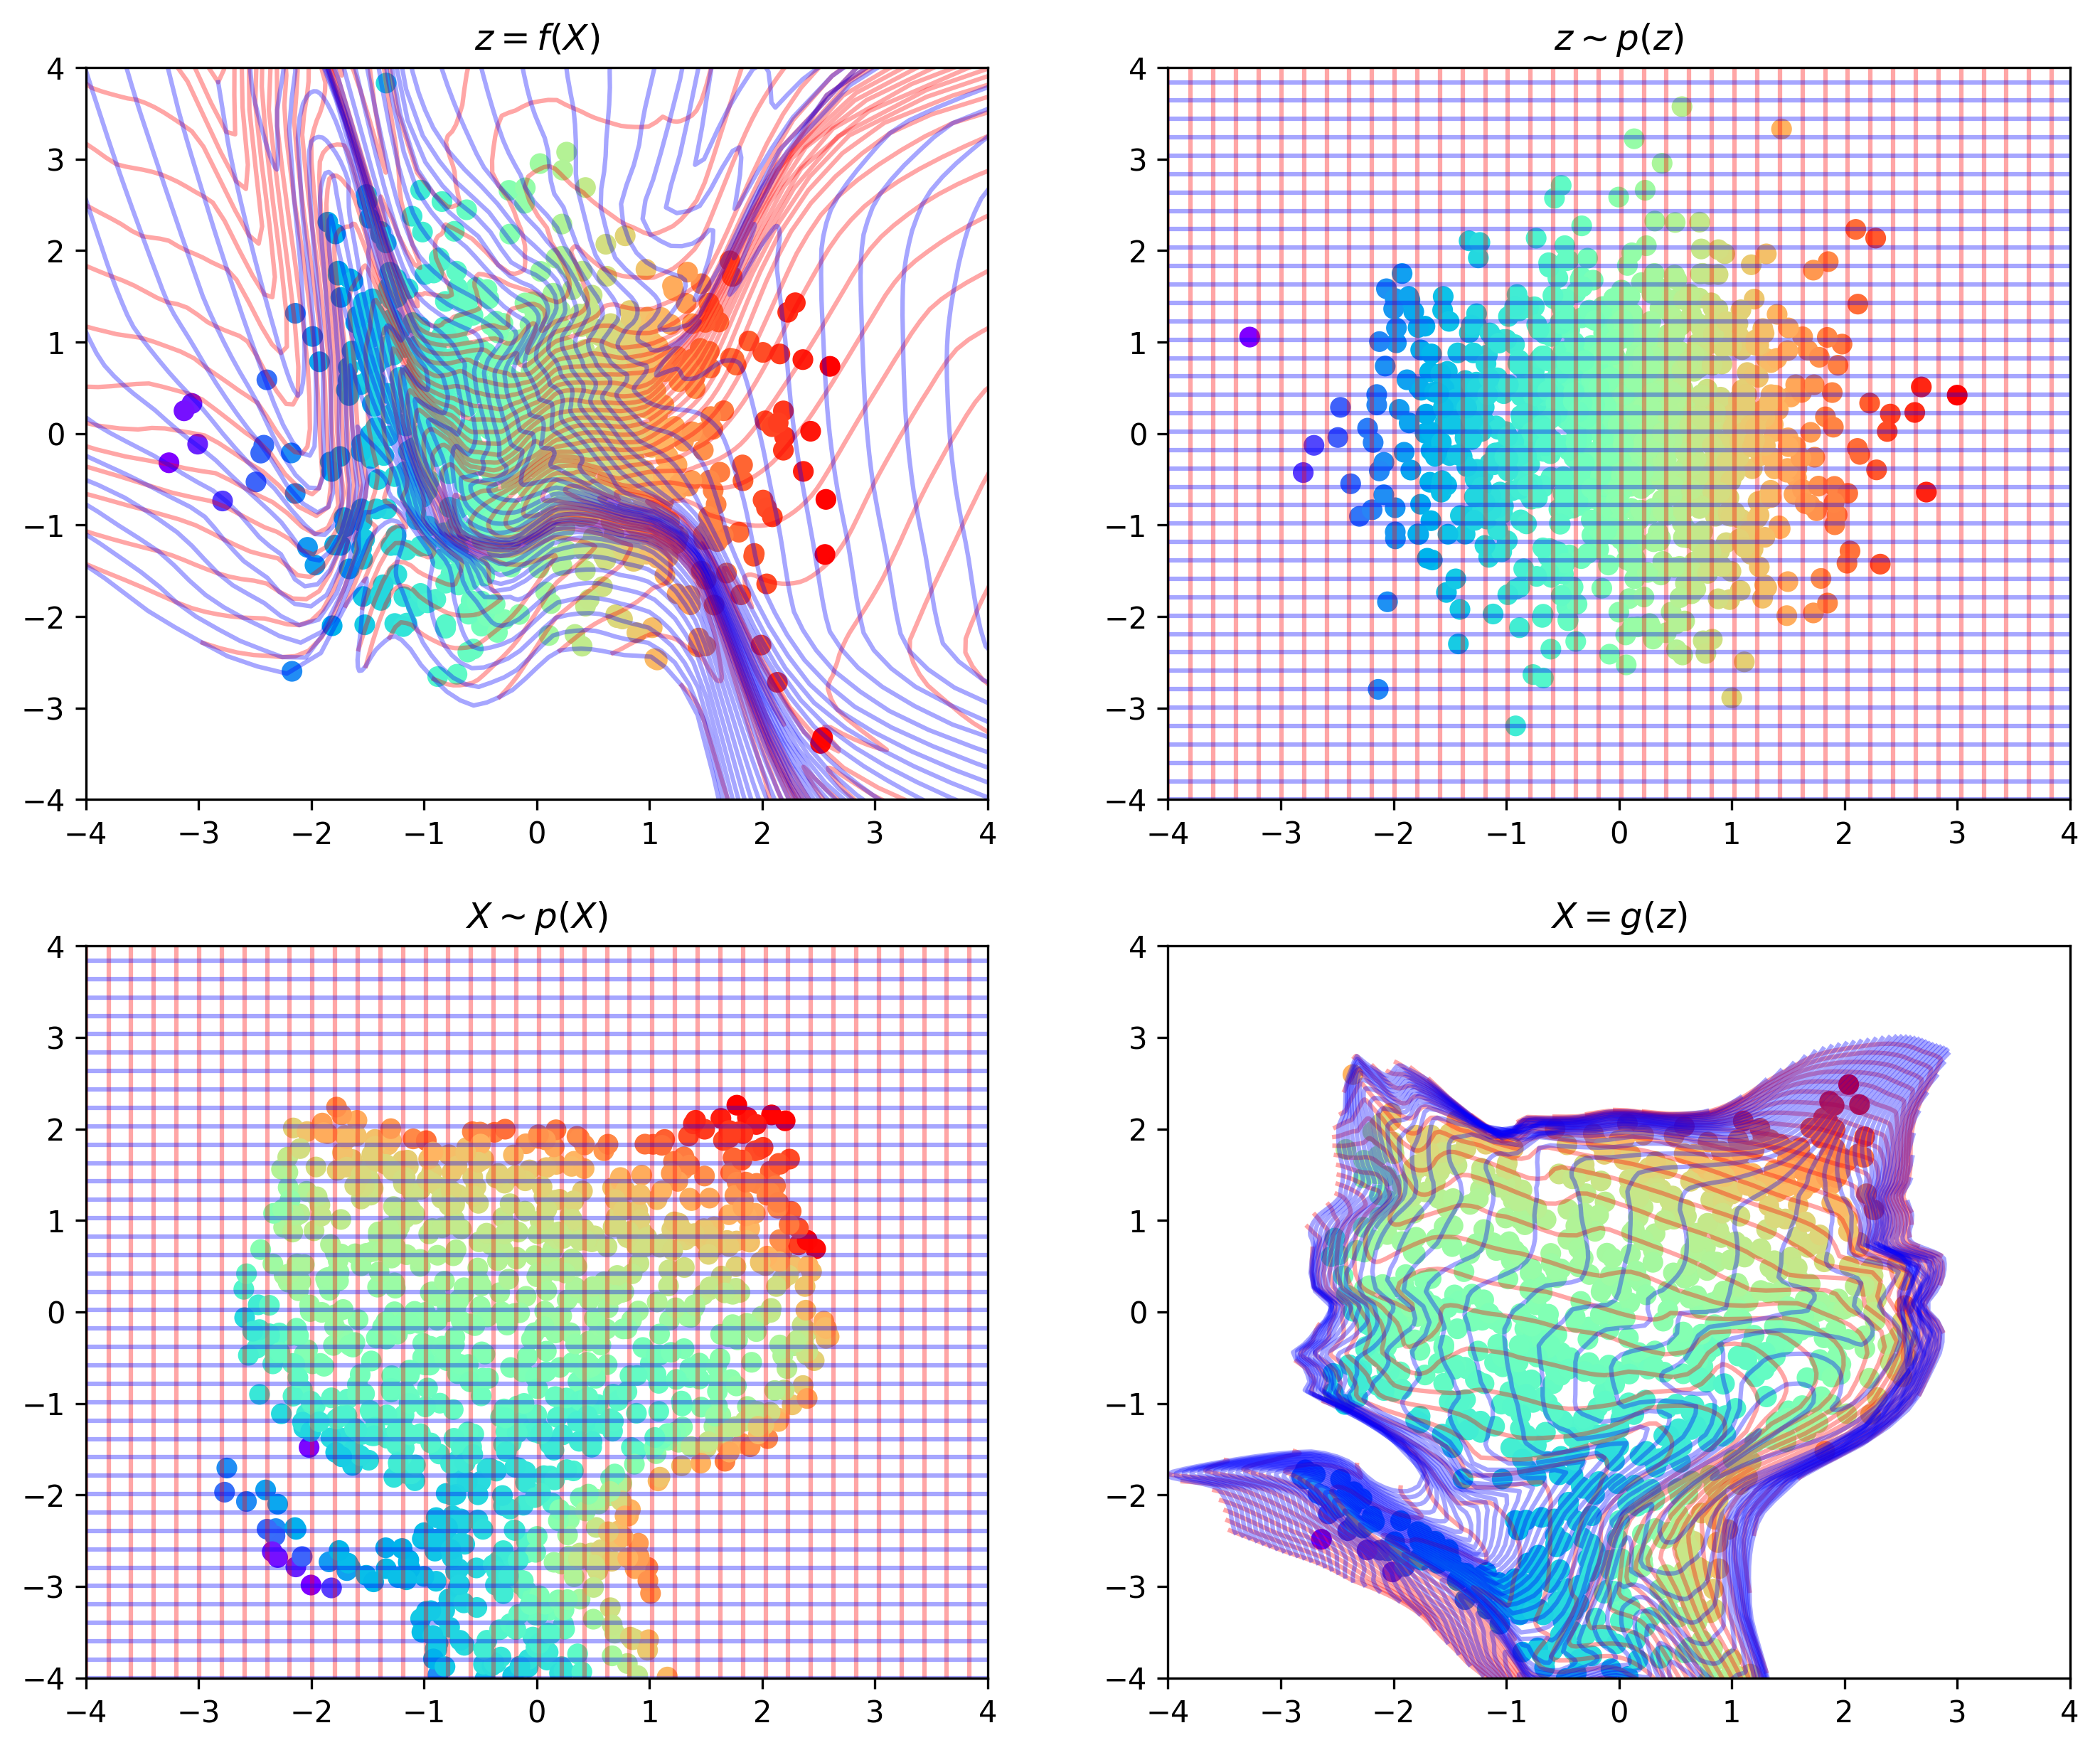

In [73]:
plt.figure(figsize=(12, 10))


grid_points = 200
grid_freq = 5
z_lims = [-4, 4]
x_lims = [-4, 4]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow.f(torch.from_numpy(data))[0].detach().numpy()


plt.subplot(221)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(inv[labels==0][:, 0], inv[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(inv[labels==1][:, 0], inv[labels==1][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], yy_x, xx_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

z = flow.prior.sample((1000, 1)).numpy()
plt.subplot(222)
plt.scatter(z[:, 0, 0], z[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(223)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(data[labels==0][:, 0], data[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(data[labels==1][:, 0], data[labels==1][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(224)
x = flow.g(torch.from_numpy(z).float()).detach().numpy()
g_xx, g_yy = grid_image(flow.g, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx, g_yy = grid_image(flow.g, yy_z, xx_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.scatter(data[labels==0][:, 0], data[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(data[labels==1][:, 0], data[labels==1][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)